# MLP on Simulated ORFs  
Start with ORF_MLP_118 which had the simulator bug fix.  
Evaluate MLP with wide,deep network.  
Train on copious simulated data.  
Use uniform but shorter RNA lengths: 500 
Lower accuracy: 66%.


In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-08-17 18:47:35 UTC


## Errors on first try
Went away by restarting Jupyter.

InternalError:  Blas xGEMM launch failed : a.shape=[1,32,84], b.shape=[1,84,128], m=32, n=128, k=84
	 [[node sequential_1/dense_4/MatMul (defined at home/jrm/venv/lib/python3.8/site-packages/keras/layers/core.py:1222) ]] [Op:__inference_train_function_1034]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_1/dense_4/MatMul:
 IteratorGetNext (defined at home/jrm/venv/lib/python3.8/site-packages/keras/engine/training.py:819)

Function call stack:
train_function


In [2]:
PC_TRAINS=50000
NC_TRAINS=50000
PC_TESTS=5000
NC_TESTS=5000   
RNA_LEN=500  
MAX_K = 3 
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=128
DROP_RATE=0.30
EPOCHS=200
SPLITS=3
FOLDS=3   # make this 5 for serious testing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [4]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import Collection_Generator,Transcript_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/DataPrep.py')
    with open('DataPrep.py', 'w') as f:
        f.write(r.text)  
    from DataPrep import DataPrep
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter
        from SimTools.RNA_gen import Collection_Generator,Transcript_Oracle
        from SimTools.KmerTools import KmerTools
        from SimTools.DataPrep import DataPrep
BESTMODELPATH=DATAPATH+"BestModel"  
LASTMODELPATH=DATAPATH+"LastModel"  

On Google CoLab, mount cloud-local file, get our code from GitHub.


## Data Load


In [5]:
show_time()
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(RNA_LEN)
pc_all = pc_sim.get_sequences(PC_TRAINS+PC_TESTS)
nc_all = nc_sim.get_sequences(NC_TRAINS+NC_TESTS)
print("Generated",len(pc_all),"PC seqs")
print("Generated",len(nc_all),"NC seqs")
pc_sim=None
nc_sim=None

2021-08-17 18:47:39 UTC
Generated 55000 PC seqs
Generated 55000 NC seqs


In [6]:
print("Simulated sequence characteristics:")
oc = ORF_counter()
print("PC seqs")
oc.describe_sequences(pc_all)
print("NC seqs")
oc.describe_sequences(nc_all)
oc=None
show_time()

Simulated sequence characteristics:
PC seqs
Average RNA length: 500.0
Average ORF length: 336.5314363636364
NC seqs
Average RNA length: 500.0
Average ORF length: 126.02416363636364
2021-08-17 18:48:10 UTC


## Data Prep

In [7]:
dp = DataPrep()
Xseq,y=dp.combine_pos_and_neg(pc_all,nc_all)
nc_all=None
pc_all=None
nc_all=None
print("The first few shuffled labels:")
print(y[:30])
show_time()

The first few shuffled labels:
[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1]
2021-08-17 18:48:10 UTC


In [8]:
Xfrq=KmerTools.seqs_to_kmer_freqs(Xseq,MAX_K)
Xseq = None
y=np.asarray(y)
show_time()

2021-08-17 18:48:45 UTC


In [9]:
# Assume X and y were shuffled.
train_size=PC_TRAINS+NC_TRAINS
X_train=Xfrq[:train_size] 
X_test=Xfrq[train_size:]
y_train=y[:train_size] 
y_test=y[train_size:]
print("Training set size=",len(X_train),"=",len(y_train))
print("Reserved test set size=",len(X_test),"=",len(y_test))
Xfrq=None
y=None
show_time()

Training set size= 100000 = 100000
Reserved test set size= 10000 = 10000
2021-08-17 18:48:45 UTC


## Neural network

In [10]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               10880     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)        

In [11]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=BESTMODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    # When shuffle=True, the valid indices are a random subset.
    # No need to shuffle here assuming data was shuffled above.
    splitter = KFold(n_splits=SPLITS,shuffle=False) 
    model = None
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()
    return model  # parameters at end of training

2021-08-17 18:48:48 UTC
MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 9s 3ms/step - loss: 0.6982 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4964
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/BestModel/assets
Epoch 2/200
2084/2084 [==============================] - 7s 3ms/step - loss: 0.6935 - accuracy: 0.5012 - val_loss: 0.6933 - val_accuracy: 0.4964
Epoch 3/200
2084/2084 [==============================] - 7s 3ms/step - loss: 0.6933 - accuracy: 0.4992 - val_loss: 0.6931 - val_accuracy: 0.5036
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/BestModel/assets
Epoch 4/200
2084/2084 [==============================] - 8s 4ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 5/200
2084/2084 [==============================] - 7s 3ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 6/200
2084/2084 [=======================

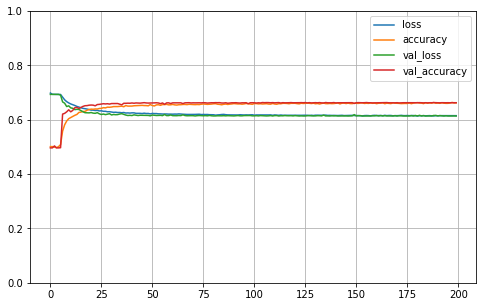

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 7s 3ms/step - loss: 0.6990 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.5035
Epoch 2/200
2084/2084 [==============================] - 7s 3ms/step - loss: 0.6935 - accuracy: 0.4956 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 3/200
2084/2084 [==============================] - 7s 3ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 4/200
2084/2084 [==============================] - 7s 3ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.4965
Epoch 5/200
2084/2084 [==============================] - 7s 3ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 6/200
2084/2084 [==============================] - 8s 4ms/step - loss: 0.6932 - accuracy: 0.4977 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 7/200
2084/2084 [==============================] - 7s 3ms/step - loss: 0.6932 - a

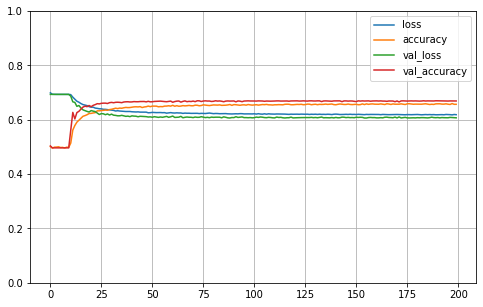

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 9s 4ms/step - loss: 0.6999 - accuracy: 0.4974 - val_loss: 0.6932 - val_accuracy: 0.5006
Epoch 2/200
2084/2084 [==============================] - 7s 3ms/step - loss: 0.6935 - accuracy: 0.4971 - val_loss: 0.6931 - val_accuracy: 0.4994
Epoch 3/200
2084/2084 [==============================] - 8s 4ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6963 - val_accuracy: 0.4994
Epoch 4/200
2084/2084 [==============================] - 7s 3ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.5006
Epoch 5/200
2084/2084 [==============================] - 8s 4ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.5006
Epoch 6/200
2084/2084 [==============================] - 8s 4ms/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 7/200
2084/2084 [==============================] - 8s 4ms/step - loss: 0.6932 - a

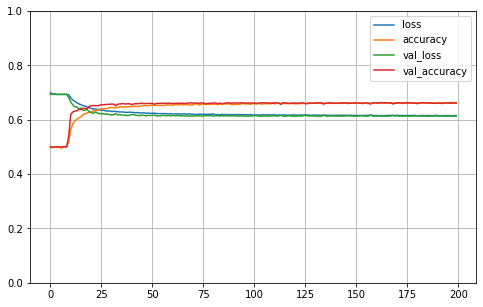

In [12]:
show_time()
last_model = do_cross_validation(X_train,y_train)
best_model = load_model(BESTMODELPATH)

In [13]:
def show_test_AUC(model,X,y):
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Accuracy on training data.
2021-08-17 20:05:09 UTC


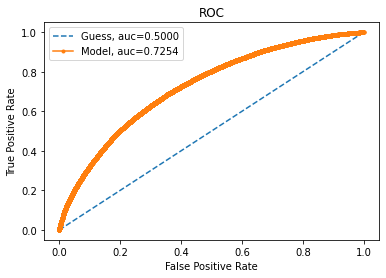

AUC: 72.54%
accuracy: 66.47%
2021-08-17 20:05:15 UTC


In [14]:
print("Accuracy on training data.")
show_time()
show_test_AUC(best_model,X_train,y_train)
show_test_accuracy(best_model,X_train,y_train)
show_time()

Accuracy on test data.
2021-08-17 20:05:15 UTC


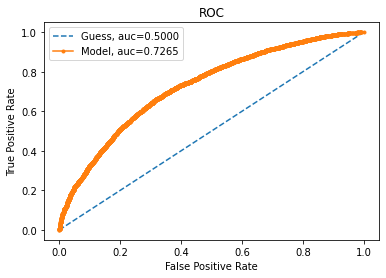

AUC: 72.65%
accuracy: 67.03%
2021-08-17 20:05:17 UTC


In [15]:
print("Accuracy on test data.")
show_time()
show_test_AUC(last_model,X_test,y_test)
show_test_accuracy(best_model,X_test,y_test)
show_time()